In [1]:
import pandas as pd
import math
import numpy as np
from scipy.stats import shapiro 
import scipy.stats as stats
from scipy.special import erfc

In [2]:
df = pd.read_excel('aaa.xlsx')
df['Значение_1'] = df[['Значение_1']].astype(float)
df

,Точка,Матрикс,Значение_1,Значение_2,Значение_3,Значение_4,Значение_5
0,1,Поб (без поля),402875.0,372479,321258,511730,397145
1,1,М14 (без поля),1088455.0,1139811,484984,856456,1041174
2,1,М14 GO (без поля),1665347.0,437046,1114317,955573,872998
3,1,Поб (с мп),131429.0,51523,209075,230000,212004
4,1,М14 (с мп),954388.0,1055744,1327124,1126324,1456562
5,1,М14 GO (с мп),1655380.0,539483,1470316,1324671,539483
6,2,Поб (без поля),1485374.0,2089270,1568318,1398373,1041732
7,2,М14 (без поля),1448369.0,1103819,1138000,892129,764611
8,2,М14 GO (без поля),1194059.0,1626223,1187739,1613351,782591
9,2,Поб (с мп),71068.0,39617,292551,255000,403040


In [3]:
df.groupby(list(df.columns[:2])).size().max()

1

In [16]:
import pandas as pd
import math
import numpy as np
from scipy.stats import shapiro 
import scipy.stats as stats
from scipy.special import erfc
from datetime import datetime

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

pd.set_option('display.float_format', lambda x: '%.3f' % x)

import matplotlib.pyplot as plt
plt.style.use('classic')
plt.rcParams["figure.autolayout"] = True
import seaborn as sns
sns.set()



class OutliesCorrect:
    
    def __init__(
        self,
        df: pd.core.frame.DataFrame):
        
        if df.shape[1] < 3 or df.shape[0] < 2:
            raise ValueError('Некоректные данные - размер таблицы')
        
        if df.groupby(list(df.columns[:2])).size().max() > 1:
            raise ValueError('Некоректные данные - дубли в таблице')
    
        self.columns = list(df.columns)
        self.day_headers = self.columns[0]
        self.matrix_headers = self.columns[1]
    
        self.points_names = self.columns[2:]
    
        self.matrixs = sorted(list(df[self.matrix_headers].unique()))
        self.days = sorted(list(df[self.day_headers].unique()))
        
        df[self.points_names] = df[self.points_names].astype(float)
        
        self.data = df.copy()
        
    def add_criteria(self,
                    criteria: str = "quantile", # 'quantile', 'z_score', 'chauvenet'
                    norm_type: str = 'avg', # 'avg', 'drop'
                    options: dict = None, # dict with values for criteria - {'min_value', 'max_value', 'value', 'n'}
                    only_normal: int = 0 # Замена значений только для нормально распределенных строк (0 - нет, 1 - да, 2 = только перв.)
                    ):
        
        if norm_type not in ['avg', 'drop']:
            norm_type = 'avg'
            print('norm_type parametr to default == avg')
            
        if only_normal not in [1, 2, 0]:
            only_normal = 0
            print('only_normal parametr to default == 0')
            
        if criteria not in ['quantile', 'z_score', 'chauvenet']:
            criteria = 'quantile'
            print('Criteria parametr to default == quantile')
            
        self.criteria = criteria
        self.norm_type = norm_type
        self.only_normal = only_normal
        
        if criteria == 'quantile':
            
            if options is None:
                self.min_value = 0.05
                self.max_value = 0.95
                
            elif 'max_value' not in options.keys() or 'min_value' not in options.keys():
                raise AttributeError('Некоректные параметры для Quantile')
            
            else:
                self.min_value = options['min_value']
                self.max_value = options['max_value']
                
                
        elif criteria == 'z_score':
            if options is None:
                self.min_value = -1
                self.max_value = 1
                
            elif 'min_value' not in options.keys() or 'max_value' not in options.keys():
                raise AttributeError('Некоректные параметры для z_score')
                
            else:
                self.min_value = options['min_value']
                self.max_value = options['max_value']
                
                
        elif criteria == 'chauvenet':
            
            if options is None:
                print('Значение для chauvenet будет расчитано по 1/2*N')
                self.criteria_n = 2
                self.value = None
            elif 'n' in options.keys():
                print(f"Значение для chauvenet будет расчитано по 1/2*{options['n']}")
                self.criteria_n = options['n']
                self.value = None
            elif 'value' in options.keys():
                print(f"Значение для chauvenet будет расчитано по критерию {options['value']}")
                self.value = options['value']
                self.criteria_n = None
            else:
                raise AttributeError('Некоректные параметры для chauvenet')
            
        else:
            raise AttributeError("Некоректный критерий 'criteria'")
        
        return self
    
    
    def normal_check(self):
        
        try:
            return self.normal_info.copy()
        except AttributeError as ex: 
            df_temp = self.data.copy()
            df_temp['normal_d'] = df_temp.apply(lambda x: shapiro(x[df_temp.columns[2:]])[1] > 0.05, axis=1)
            self.normal_info = df_temp.copy()
            return df_temp
    
    
    def print_normal_stats(self):
        try:
            self.normal_info
        except AttributeError as ex:
            self.normal_check()

        df_temp = self.normal_info.copy()
        
        normal_info = dict(df_temp[df_temp[self.day_headers]==self.days[0]][[self.matrix_headers, 'normal_d']].values)
        
        print('Shapiro-Wilk Test (on start day) : ')
        for i in normal_info.keys():
            if not normal_info[i]:
                print(i, "- \x1b[31m NOT Norm \x1b[0m")
            else:
                print(i, "- \x1b[32m Norm \x1b[0m")
        
        return df_temp
    
    
    
    def quantile_calc(self, get_flags: bool = False):
        
        try:
            self.max_value
            self.max_value
        except AttributeError as ex:
            raise AttributeError(f"No options for method {ex}")
        
        
        def quantile_calc_row(l, get_flags):
        
            norm_flg = l[len(l)-1]
            l_values = np.array(l[2:-1])
        
            normal_check_ = ((self.only_normal == 1) or (self.only_normal == 2 and l[0] != self.days[0]))
        
            if not norm_flg and normal_check_:
                return pd.Series(l)
        
            q_up = np.quantile(l_values, self.max_value)
            q_low = np.quantile(l_values, self.min_value)
        
            flags = []
            result = []
        
            for i in range(0, len(l_values)):
                if l_values[i] > q_up or l_values[i] < q_low:
                    flags.append(0)
                else:
                    flags.append(1)
                
            l_values_n = l_values * np.array(flags)
        
            for i in range(0, len(flags)):
                if flags[i] == 1:
                    result.append(l_values[i])
                else:
                    if self.norm_type == 'avg':
                        result.append(np.mean(l_values_n[l_values_n > 0]))
                    else:
                        result.append(np.NaN)
                
            if not get_flags:
                return pd.Series(l[0:2] + list(result) + [norm_flg])
            else:
                return pd.Series(l[0:2] + list(flags) + [norm_flg])
                
        
        df_norm = self.normal_check().apply(lambda x: quantile_calc_row(list(x), get_flags), axis=1)
        df_norm.columns = self.columns + ['normal_d']
        return df_norm 
    
    
    def z_score_calc(self, get_flags: bool = False):
        
        try:
            self.max_value
            self.max_value
        except AttributeError as ex:
            raise AttributeError(f"No options for method {ex}")
        
        
        def z_score_calc_row(l, get_flags):
        
            norm_flg = l[len(l)-1]
            l_values = np.array(l[2:-1])
        
            normal_check_ = ((self.only_normal == 1) or (self.only_normal == 2 and l[0] != self.days[0]))
        
            if not norm_flg and normal_check_:
                return pd.Series(l)
        
            z_max = self.max_value
            z_min = self.min_value
        
            z_scores = stats.zscore(l_values)
        
            flags = []
            result = []
        
            for i in range(0, len(z_scores)):
                if z_scores[i] > z_max or z_scores[i] < z_min:
                    flags.append(0)
                else:
                    flags.append(1)
                
            l_values_n = l_values * np.array(flags)
        
            for i in range(0, len(flags)):
                if flags[i] == 0:
                    if self.norm_type == 'avg':
                        result.append(np.mean(l_values_n[l_values_n > 0]))
                    else:
                        result.append(np.NaN)
                else:
                    result.append(l_values[i])
                
            if not get_flags:
                return pd.Series(l[0:2] + list(result) + [norm_flg])
            else:
                return pd.Series(l[0:2] + list(flags) + [norm_flg])
        
        df_norm = self.normal_check().apply(lambda x: z_score_calc_row(list(x), get_flags), axis=1)
        df_norm.columns = self.columns + ['normal_d']
        return df_norm 
    
    
    def chauvenet_calc(self, get_flags: bool = False):
        
        def chauvenet_calc_row(l, get_flags):
        
            norm_flg = l[len(l)-1]
            l_values = np.array(l[2:-1])
        
            normal_check_ = ((self.only_normal == 1) or (self.only_normal == 2 and l[0] != self.days[0]))
        
            if not norm_flg and normal_check_:
                return pd.Series(l)
        
            if self.value is None:
                criteria_limit = 1.0 / ( self.criteria_n * len(l_values[l_values>0]))
            else:
                criteria_limit = self.value
        
            mean_v = l_values.mean()
            std_v = l_values.std()
            dist = abs(l_values - mean_v) / std_v
            prob = erfc(dist)
            flags = (prob >= criteria_limit) * 1
        
            l_values_n = l_values * flags
            result = [] 

        
            for i in range(0, len(flags)):
                if flags[i] == 0:
                    if self.norm_type == 'avg':
                        result.append(np.mean(l_values_n[l_values_n > 0]))
                    else:
                        result.append(np.NaN)
                else:
                    result.append(l_values[i])
                                  
            if not get_flags:
                return pd.Series(l[0:2] + list(result) + [norm_flg])
            else:
                return pd.Series(l[0:2] + list(flags) + [norm_flg])
        
        df_norm = self.normal_check().apply(lambda x: chauvenet_calc_row(list(x), get_flags), axis=1)
        df_norm.columns = self.columns + ['normal_d']
        return df_norm 
    
    
    def create_norm_df(self):
        if self.criteria == 'z_score':
            self.norm_data = self.z_score_calc()
            return self
        elif self.criteria == 'quantile':
            self.norm_data = self.quantile_calc()
            return self
        elif self.criteria == 'chauvenet':
            self.norm_data = self.chauvenet_calc()
            return self
        else:
            print('No saved options for norm')
            return None
        
        
    def get_norm_df(self):
        try:
            self.norm_data
        except AttributeError as ex:
            raise AttributeError(f"No calculate norm data")
        else:
            return self.norm_data.copy()
        
    
    def get_criteria_flags(self):
        if self.criteria == 'z_score':
            return self.z_score_calc(True)
        elif self.criteria == 'quantile':
            return self.quantile_calc(True)
        elif self.criteria == 'chauvenet':
            return self.chauvenet_calc(True)
        else:
            print('No saved options for norm')
            return None
        
        
    def get_norm_avg_df(self):
        try:
            return self.norm_data_avg.copy()
        except AttributeError as ex:
            df_avg = self.get_norm_df()[[self.day_headers, self.matrix_headers]]
            df_avg['avg_points_value'] = self.norm_data[self.points_names].apply(lambda x: np.mean(x), axis=1)
            self.norm_data_avg = df_avg.copy()
            return df_avg
    
    
    def get_rolls(self):
        try:
            return self.norm_data_rolls.copy()
        except AttributeError as ex:
            df_temp = self.get_norm_df()
            df_first = df_temp[df_temp[self.day_headers] == self.days[0]]
            first_dict = {}
            for index, row in df_first.iterrows():
                first_dict[row[self.matrix_headers]] = {}
                for point in self.points_names:
                    first_dict[row[self.matrix_headers]][point] = row[point]
            self.first_dict = first_dict.copy()
            
            for index, row in df_temp.iterrows():
                for point in self.points_names:
                    df_temp.loc[index, point] = row[point] / self.first_dict[row[self.matrix_headers]][point]
            
            self.norm_data_rolls = df_temp.copy()
            return df_temp
        
        
    def get_avg_rolls(self):
        try:
            return self.norm_data_avg_rolls.copy()
        except AttributeError as ex:
            df_temp = self.get_norm_avg_df()
            df_first = df_temp[df_temp[self.day_headers] == self.days[0]]
            self.first_avg_dict = df_first.set_index(self.matrix_headers)[['avg_points_value']].to_dict()['avg_points_value']
            for index, row in df_temp.iterrows():
                df_temp.loc[index, 'avg_points_value'] = row['avg_points_value'] / self.first_avg_dict[row[self.matrix_headers]]
            self.norm_data_avg_rolls = df_temp.copy()
            return df_temp
        
    def get_avg_deviations(self,
                           strictly: bool = False,
                           agg: bool = False):
        try:
            if agg:
                df_deviations = self.norm_data_avg_deviations.copy()
                df_deviations['side'] = df_deviations[self.day_headers].astype(str) + df_deviations['side']
                return df_deviations.pivot_table('avg_points_deviation',
                                                 ['side'],
                                                 [self.matrix_headers]).reset_index()
            else:
                return self.norm_data_avg_deviations.copy()
        except AttributeError as ex:
            df_avg_temp = self.get_avg_rolls()
            df_roll_temp = self.get_rolls()
            
            if agg:
                df_deviations = pd.DataFrame(columns = [self.day_headers, self.matrix_headers, 'avg_points_deviation'])
            else:
                df_deviations = pd.DataFrame(columns = [self.day_headers, 'side', self.matrix_headers, 'avg_points_deviation'])
            
            for index, row in df_avg_temp.iterrows():
                matrix = row[self.matrix_headers]
                day = row[self.day_headers]
                avg_value = row['avg_points_value']
                
                roll_row = df_roll_temp.loc[(df_roll_temp[self.day_headers] == day) & (df_roll_temp[self.matrix_headers] == matrix)]
                roll_row = np.array(roll_row[self.points_names].values[0])
                
                if strictly:
                    hight_d = roll_row[(roll_row > 0) & (roll_row > avg_value)].mean() - avg_value
                    low_d = avg_value - roll_row[(roll_row > 0) & (roll_row < avg_value)].mean()
                else:
                    hight_d = roll_row[(roll_row > 0) & (roll_row >= avg_value)].mean() - avg_value
                    low_d = avg_value - roll_row[(roll_row > 0) & (roll_row <= avg_value)].mean()
                
                if agg:
                    new_row_h = [str(day) + '+', matrix, hight_d]
                    df_deviations.loc[len(df_deviations)] = new_row_h
                    new_row_l = [str(day) + '-', matrix, low_d]
                    df_deviations.loc[len(df_deviations)] = new_row_l
                else:
                    new_row_h = [day, '+', matrix, hight_d]
                    df_deviations.loc[len(df_deviations)] = new_row_h
                    new_row_l = [day, '-', matrix, low_d]
                    df_deviations.loc[len(df_deviations)] = new_row_l
                    
            df_deviations.fillna(0, inplace=True)
            self.norm_data_avg_deviations = df_deviations.copy()
                
            if agg:
                return df_deviations.pivot_table('avg_points_deviation',
                                                 [self.day_headers],
                                                 [self.matrix_headers]).reset_index()
            else:
                return df_deviations
        
        
    def get_norm_info(self):
        info = pd.DataFrame(columns = ['Options', 'Value', 'Meaning', 'Can change'])
        info.loc[len(info)] = ['Criteria', self.criteria, 'Метод определения выбросов данных', True]
        info.loc[len(info)] = ['Norm_type', self.norm_type, 'Действия с выбросами', True]
        try:
            min_value = str(self.min_value)
        except AttributeError as ex:
            min_value = 'No'
        try:
            max_value = str(self.max_value)
        except AttributeError as ex:
            max_value = 'No'
        try:
            value = str(self.value)
        except AttributeError as ex:
            value = 'No'
        try:
            criteria_n = str(self.criteria_n)
        except AttributeError as ex:
            criteria_n = 'No'
        params = 'Min = ' + str(min_value) + ', Max = ' + str(max_value) + ', chauvenet_const = ' + str(value) + ', chauvenet_n' + str(criteria_n)
        info.loc[len(info)] = ['Rriteria parametrs', params, 'Параметры метода', True]
        info.loc[len(info)] = ['Only_normal', self.only_normal, 'Применять поиск выбросов только к норм. распределению', True]
        info.loc[len(info)] = ['Norm. dist. criteria', 'тест Шапиро-Уилка', 'Критерий норм. распределения', False]
        return info
        
        
    def to_excel(self,
                 data: list = ['base', 'flags', 'norm', 'avg_norm', 'rolls', 'avg_rolls', 'avg_deviations'],
                 strictly_deviations: bool = False,
                 file_name: str = None):
        
        if not file_name:
            now = datetime.now().strftime("%Y-%m-%d %H_%m")
            file_name = f'Normal_date_results {now}.xlsx'
        else:
            file_name += '.xlsx'
            
        
        with pd.ExcelWriter(file_name) as writer:
            workbook = writer.book
            worksheet = workbook.add_worksheet('Data')
            writer.sheets['Data'] = worksheet
            st_row = 1
            
            if 'base' in data:
                worksheet.write(st_row, 0, 'Исходные данные')
                st_row += 1
                self.data.to_excel(writer, sheet_name='Data', startrow=st_row, index=False)
                st_row += self.data.shape[0] + 4
            if 'flags' in data:
                worksheet.write(st_row, 0, 'Флаги исключаемых значений (0 - искл., 1 - остается)')
                st_row += 1
                self.get_criteria_flags().to_excel(writer, sheet_name='Data', startrow=st_row, index=False)
                st_row += self.data.shape[0] + 4
            if 'norm' in data:
                worksheet.write(st_row, 0, 'Отнормированные значения (без выбросов)')
                st_row += 1
                self.get_norm_df().to_excel(writer, sheet_name='Data', startrow=st_row, index=False)
                st_row += self.data.shape[0] + 4
            if 'avg_norm' in data:
                worksheet.write(st_row, 0, 'Средние по норм. значениям')
                st_row += 1
                self.get_norm_avg_df().to_excel(writer, sheet_name='Data', startrow=st_row, index=False)
                st_row += self.data.shape[0] + 4
            if 'rolls' in data:
                worksheet.write(st_row, 0, 'Перекаты по всем наблюдениям')
                st_row += 1
                self.get_rolls().to_excel(writer, sheet_name='Data', startrow=st_row, index=False)
                st_row += self.data.shape[0] + 4
            if 'avg_rolls' in data:
                worksheet.write(st_row, 0, 'Перекаты по средним')
                st_row += 1
                self.get_avg_rolls().to_excel(writer, sheet_name='Data', startrow=st_row, index=False)
                st_row += self.data.shape[0] + 4
            if 'avg_deviations' in data:
                worksheet.write(st_row, 0, 'Отклонения средние')
                st_row += 1
                self.get_avg_deviations(agg=True, strictly=strictly_deviations).to_excel(writer, sheet_name='Data', startrow=st_row, index=False)
                st_row += self.data.shape[0] + 4
                
            self.get_norm_info().to_excel(writer, sheet_name='Info', startrow=0, index=False)
            
        
        print('File ' + file_name + ' saved')
        return True
    
    
    def draw_hist(self,
                  title: str = 'Plot title',
                  xlabel: str = None,
                  ylabel: str = None,
                  deviations: bool = True):
        
        df_avg_date = self.get_avg_rolls()
        df_errors = self.get_avg_deviations()
        
        day_labels = {d: 'День '+str(d) for d in self.days}
        
        df_avg_date[self.day_headers] = df_avg_date[self.day_headers].apply(lambda x: day_labels[x])
        
        df_avg_date['avg_points_value'] = df_avg_date['avg_points_value'] * 100
        df_errors['avg_points_deviation'] = df_errors['avg_points_deviation'] * 100
        
        fig, ax = plt.subplots()
        fig.patch.set_visible(False)

        ax = sns.barplot(data=df_avg_date,
                         x=self.matrix_headers,
                         y='avg_points_value',
                         hue=self.day_headers,
                         palette='pastel')
        
        ax.tick_params(left=False, labelleft=False)
        ax.set_title(title, fontdict = { 'fontsize': 15})
        ax.set(xlabel=xlabel, ylabel=ylabel)
        plt.legend(title=None)

        x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
        y_coords = [p.get_height() for p in ax.patches]
        
        if deviations:
            errors = [df_errors[df_errors['side'] == '-']["avg_points_deviation"], df_errors[df_errors['side'] == '+']["avg_points_deviation"]]
            ax.errorbar(x=x_coords, y=y_coords, yerr=errors, fmt="none", c="k", elinewidth=1)

        sns.despine(trim=True, offset=2)
        plt.margins(0.01, 0.01)
        plt.tight_layout()
        plt.show()
        
    
    @classmethod
    def read_excel(cls, file_path: str):
        return cls(pd.read_excel(file_path))

In [18]:
data = OutliesCorrect.read_excel("Result.xlsx")
data.add_criteria(criteria = 'chauvenet', norm_type = 'avg',  only_normal = 0)
data.create_norm_df().get_norm_df()

Значение для chauvenet будет расчитано по 1/2*N


,Точка,Матрикс,Значение_1,Значение_2,Значение_3,Значение_4,Значение_5,normal_d
0,1,Поб (без поля),402875.000,372479.000,390833.000,390833.000,397145.000,True
1,1,М14 (без поля),1088455.000,1139811.000,1031474.000,856456.000,1041174.000,True
2,1,М14 GO (без поля),980962.667,980962.667,1114317.000,955573.000,872998.000,True
3,1,Поб (с мп),131429.000,195627.000,209075.000,230000.000,212004.000,True
4,1,М14 (с мп),1169730.667,1055744.000,1327124.000,1126324.000,1169730.667,True
5,1,М14 GO (с мп),1655380.000,1483455.667,1470316.000,1324671.000,1483455.667,True
6,2,Поб (без поля),1485374.000,1484021.667,1568318.000,1398373.000,1484021.667,True
7,2,М14 (без поля),1044649.333,1103819.000,1138000.000,892129.000,1044649.333,True
8,2,М14 GO (без поля),1194059.000,1626223.000,1187739.000,1613351.000,1405343.000,True
9,2,Поб (с мп),71068.000,206206.333,292551.000,255000.000,206206.333,True


In [9]:
data.print_normal_stats()

Shapiro-Wilk Test (on start day) : 
Поб (без поля) -  Norm 
М14 (без поля) -  Norm 
М14 GO (без поля) -  Norm 
Поб (с мп) -  Norm 
М14 (с мп) -  Norm 
М14 GO (с мп) -  Norm 


,Точка,Матрикс,Значение_1,Значение_2,Значение_3,Значение_4,Значение_5,normal_d
0,1,Поб (без поля),402875.000,372479.000,321258.000,511730.000,397145.000,True
1,1,М14 (без поля),1088455.000,1139811.000,484984.000,856456.000,1041174.000,True
2,1,М14 GO (без поля),1665347.000,437046.000,1114317.000,955573.000,872998.000,True
3,1,Поб (с мп),131429.000,51523.000,209075.000,230000.000,212004.000,True
4,1,М14 (с мп),954388.000,1055744.000,1327124.000,1126324.000,1456562.000,True
5,1,М14 GO (с мп),1655380.000,539483.000,1470316.000,1324671.000,539483.000,True
6,2,Поб (без поля),1485374.000,2089270.000,1568318.000,1398373.000,1041732.000,True
7,2,М14 (без поля),1448369.000,1103819.000,1138000.000,892129.000,764611.000,True
8,2,М14 GO (без поля),1194059.000,1626223.000,1187739.000,1613351.000,782591.000,True
9,2,Поб (с мп),71068.000,39617.000,292551.000,255000.000,403040.000,True


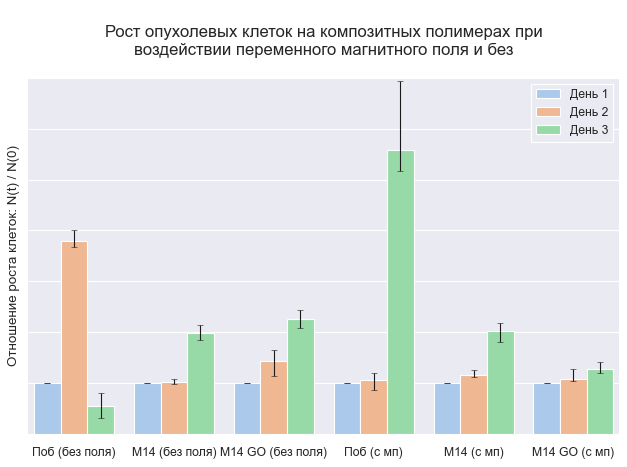

In [14]:
title = '''
Рост опухолевых клеток на композитных полимерах при
воздействии переменного магнитного поля и без
'''
ylabel='Отношение роста клеток: N(t) / N(0)'
data.draw_hist(title = title, ylabel=ylabel)

In [5]:
a.get_norm_info()

,Options,Value,Meaning,Can change
0,Criteria,z_score,Метод определения выбросов данных,True
1,Norm_type,avg,Действия с выбросами,True
2,Rriteria parametrs,"Min = -1, Max = 1, chauvenet_const = No, chauv...",Параметры метода,True
3,Only_normal,0,Применять поиск выбросов только к норм. распре...,True
4,Norm. dist. criteria,тест Шапиро-Уилка,Критерий норм. распределения,False


In [6]:
a.get_criteria_flags()

,Точка,Матрикс,Значение_1,Значение_2,Значение_3,Значение_4,Значение_5,normal_d
0,1,Поб (без поля),1,1,0,0,1,True
1,1,М14 (без поля),1,1,0,1,1,True
2,1,М14 GO (без поля),0,0,1,1,1,True
3,1,Поб (с мп),1,0,1,1,1,True
4,1,М14 (с мп),0,1,1,1,0,True
5,1,М14 GO (с мп),0,0,1,1,0,True
6,2,Поб (без поля),1,0,1,1,0,True
7,2,М14 (без поля),0,1,1,1,0,True
8,2,М14 GO (без поля),1,0,1,0,0,True
9,2,Поб (с мп),0,0,1,1,0,True


In [28]:
a.to_excel()

File Normal_date_results 2023-08-25 00_08.xlsx saved


True

In [26]:
a.get_avg_deviations(agg=True)

Матрикс,side,М14 (без поля),М14 (с мп),М14 GO (без поля),М14 GO (с мп),Поб (без поля),Поб (с мп)
0,1+,0.000,0.000,0.000,0.000,0.000,0.000
1,1-,0.000,0.000,0.000,0.000,0.000,0.000
2,2+,0.060,0.096,0.046,0.060,0.201,0.342
3,2-,0.036,0.085,0.074,0.028,0.130,0.100
4,3+,0.219,0.163,0.113,0.032,0.242,1.364
5,3-,0.084,0.210,0.085,0.029,0.248,0.401


In [29]:
a.print_normal_stats()

Shapiro-Wilk Test (on start day) : 
Поб (без поля) -  Norm 
М14 (без поля) -  Norm 
М14 GO (без поля) -  Norm 
Поб (с мп) -  Norm 
М14 (с мп) -  Norm 
М14 GO (с мп) -  Norm 


,Точка,Матрикс,Значение_1,Значение_2,Значение_3,Значение_4,Значение_5,normal_d
0,1,Поб (без поля),402875.000,372479.000,321258.000,511730.000,397145.000,True
1,1,М14 (без поля),1088455.000,1139811.000,484984.000,856456.000,1041174.000,True
2,1,М14 GO (без поля),1665347.000,437046.000,1114317.000,955573.000,872998.000,True
3,1,Поб (с мп),131429.000,51523.000,209075.000,230000.000,212004.000,True
4,1,М14 (с мп),954388.000,1055744.000,1327124.000,1126324.000,1456562.000,True
5,1,М14 GO (с мп),1655380.000,539483.000,1470316.000,1324671.000,539483.000,True
6,2,Поб (без поля),1485374.000,2089270.000,1568318.000,1398373.000,1041732.000,True
7,2,М14 (без поля),1448369.000,1103819.000,1138000.000,892129.000,764611.000,True
8,2,М14 GO (без поля),1194059.000,1626223.000,1187739.000,1613351.000,782591.000,True
9,2,Поб (с мп),71068.000,39617.000,292551.000,255000.000,403040.000,True


In [340]:
a = OutliesCorrect(df)

a.add_criteria(criteria = 'z_score')

b = a.create_norm_df().get_avg_rolls()

b['avg_points_value'] = b['avg_points_value'] * 100
errors = a.get_avg_deviations()
errors['avg_points_deviation'] = errors['avg_points_deviation'] * 100
b

,Точка,Матрикс,avg_points_value
0,1,Поб (без поля),100.000
1,1,М14 (без поля),100.000
2,1,М14 GO (без поля),100.000
3,1,Поб (с мп),100.000
4,1,М14 (с мп),100.000
5,1,М14 GO (с мп),100.000
6,2,Поб (без поля),379.707
7,2,М14 (без поля),101.277
8,2,М14 GO (без поля),121.401
9,2,Поб (с мп),139.948


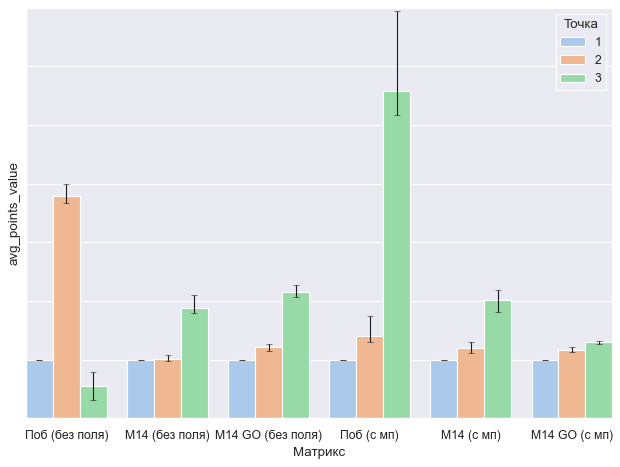

In [341]:
import matplotlib.pyplot as plt
plt.style.use('classic')
plt.rcParams["figure.autolayout"] = True
import seaborn as sns
sns.set()

fig, ax = plt.subplots()
fig.patch.set_visible(False)
plt.rcParams["figure.autolayout"] = True

ax = sns.barplot(data=b, x='Матрикс', y='avg_points_value', hue='Точка', palette='pastel')
ax.tick_params(left=False, labelleft=False)

x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]
errs_2 = [errors[errors['side'] == '-']["avg_points_deviation"], errors[errors['side'] == '+']["avg_points_deviation"]]
ax.errorbar(x=x_coords, y=y_coords, yerr=errs_2, fmt="none", c="k", elinewidth=1)

sns.despine()
plt.tight_layout()
plt.show()

In [285]:
errors

,Точка,side,Матрикс,avg_points_deviation
0,1,+,Поб (без поля),0.000
1,1,-,Поб (без поля),0.000
2,1,+,М14 (без поля),0.000
3,1,-,М14 (без поля),0.000
4,1,+,М14 GO (без поля),0.000
5,1,-,М14 GO (без поля),0.000
6,1,+,Поб (с мп),0.000
7,1,-,Поб (с мп),0.000
8,1,+,М14 (с мп),0.000
9,1,-,М14 (с мп),0.000


In [361]:
a = [1, 2, 3]
{i: str(i) for i in a}

{1: '1', 2: '2', 3: '3'}

In [210]:
import matplotlib.pyplot as plt
import seaborn as sns

In [308]:
erfc(1)

0.15729920705028516

In [176]:
a.get_avg_deviations(agg=True).head(10)

,Точка,Матрикс,avg_points_deviation
0,1+,Поб (без поля),0.000
1,1-,Поб (без поля),0.000
2,1+,М14 (без поля),0.000
3,1-,М14 (без поля),0.000
4,1+,М14 GO (без поля),0.000
5,1-,М14 GO (без поля),0.000
6,1+,Поб (с мп),0.000
7,1-,Поб (с мп),0.000
8,1+,М14 (с мп),0.000
9,1-,М14 (с мп),0.000


In [184]:
a.get_avg_deviations(agg=True).pivot_table('avg_points_deviation', ['Точка'], ['Матрикс'])

Матрикс,М14 (без поля),М14 (с мп),М14 GO (без поля),М14 GO (с мп),Поб (без поля),Поб (с мп)
Точка,,,,,,
1+,0.000,0.000,0.000,0.000,0.000,0.000
1-,0.000,0.000,0.000,0.000,0.000,0.000
2+,0.093,0.208,0.219,1.487,0.459,0.413
2-,0.130,0.118,0.291,0.349,0.251,0.335
3+,0.209,0.108,0.178,1.586,0.291,1.045
3-,0.273,0.337,0.179,0.382,0.265,0.642


In [298]:
def norm(
    df: pd.core.frame.DataFrame,
    criteria: str = "quantile", # 'quantile', 'z_score', 'chauvenet'
    norm_type: str = 'avg', # 'avg', 'drop'
    # dict with values for criteria - {'upper_value', 'lower_value', 'min_value', 'max_value', 'value', 'n'}
    options: dict = None,
    only_normal: int = 0, # Замена значений только для нормально распределенных строк (0 - нет, 1 - да, 2 = только перв.)
    drop_null: bool = False # Удалять null значения
    ):
    
    if df.shape[1] < 3 or df.shape[0] < 2:
        return 'Некоректные данные'
    
    cols = list(df.columns)
    day_h = cols[0]
    matrix_h = cols[1]
    
    points = cols[2:]
    
    matrixs = sorted(list(df[matrix_h].unique()))
    days = sorted(list(df[day_h].unique()))
    
    if len(points) < 2:
        return 'Некоректные данные'
    
    if criteria == 'quantile':
        if options is None:
            options = {'upper_value': 0.95, 'lower_value': 0.05}
        elif 'upper_value' not in options.keys() or 'lower_value' not in options.keys():
            return 'Некоректные параметры для Quantile'
    elif criteria == 'z_score':
        if options is None:
            options = {'min_value': -1, 'max_value': 1}
        elif 'min_value' not in options.keys() or 'max_value' not in options.keys():
            return 'Некоректные параметры для z_score'
    elif criteria == 'chauvenet':
        if options is None:
            print('Значение для chauvenet будет расчитано по 1/2*N')
        elif 'n' in options.keys():
            print(f"Значение для chauvenet будет расчитано по 1/2*{options['n']}")
        elif 'value' in options.keys():
            print(f"Значение для chauvenet будет расчитано по критерию {options['value']}")
        else:
            return 'Некоректные параметры для chauvenet'
    else:
        return "Некоректный критерий 'criteria'"
    
    df_temp = df.copy()
    
    df_temp['normal_d'] = df_temp.apply(lambda x: shapiro(x[df_temp.columns[2:]])[1] > 0.05, axis=1)
    
    normal_info = dict(df_temp[df_temp[day_h]==days[0]][[matrix_h, 'normal_d']].values)
    
    print('Shapiro-Wilk Test (on start day) : ')
    for i in normal_info.keys():
        if not normal_info[i]:
            print(i, "- \x1b[31m NOT Norm \x1b[0m")
        else:
            print(i, "- \x1b[32m Norm \x1b[0m")
            
            
    def quantile_calc(l):
        
        norm_flg = l[len(l)-1]
        l_values = np.array(l[2:-1])
        
        normal_check = ((only_normal == 1) or (only_normal == 2 and l[0] != days[0]))
        
        if not norm_flg and normal_check:
            return pd.Series(l)
        
        q_up = np.quantile(l_values, options['upper_value'])
        q_low = np.quantile(l_values, options['lower_value'])
        
        flags = []
        result = []
        
        for i in range(0, len(l_values)):
            if l_values[i] > q_up or l_values[i] < q_low:
                flags.append(0)
            else:
                flags.append(1)
                
        l_values_n = l_values * np.array(flags)
        
        for i in range(0, len(flags)):
            if flags[i] == 1:
                result.append(l_values[i])
            else:
                if norm_type == 'avg':
                    l_mean = np.concatenate((l_values_n[0:i], l_values_n[i+1:]))
                    result.append(np.mean(l_mean[l_mean > 0]))
                else:
                    result.append(np.NaN)
                
        return pd.Series(l[0:2] + list(result) + [norm_flg])
    
    
    def z_score_calc(l):
        
        norm_flg = l[len(l)-1]
        l_values = np.array(l[2:-1])
        
        normal_check = ((only_normal == 1) or (only_normal == 2 and l[0] != days[0]))
        
        if not norm_flg and normal_check:
            return pd.Series(l)
        
        z_max = options['max_value']
        z_min = options['min_value']
        
        z_scores = stats.zscore(l_values)
        
        flags = []
        result = []
        
        for i in range(0, len(z_scores)):
            if z_scores[i] > z_max or z_scores[i] < z_min:
                flags.append(0)
            else:
                flags.append(1)
                
        l_values_n = l_values * np.array(flags)
        
        for i in range(0, len(flags)):
            if flags[i] == 0:
                if norm_type == 'avg':
                    l_mean = np.concatenate((l_values_n[0:i], l_values_n[i+1:]))
                    result.append(np.mean(l_mean[l_mean > 0]))
                else:
                    result.append(np.NaN)
            else:
                result.append(l_values[i])
                
        return pd.Series(l[0:2] + result + [norm_flg])
    
    
    def chauvenet_calc(l):
        
        norm_flg = l[len(l)-1]
        l_values = np.array(l[2:-1])
        
        normal_check = ((only_normal == 1) or (only_normal == 2 and l[0] != days[0]))
        
        if not norm_flg and normal_check:
            return pd.Series(l)
        
        if options is None:
            criteria_limit = 1.0 / ( 2 * len(l_values[l_values>0]))
        elif 'value' in options.keys():
            criteria_limit = options['value']
        elif 'n' in options.keys():
            criteria_limit = 1.0 / ( options['n'] * len(l_values[l_values>0]))
        
        mean_v = l_values.mean()
        std_v = l_values.std()
        dist = abs(l_values - mean_v) / std_v
        prob = erfc(dist)
        flags = (prob > criteria_limit) * 1
        
        l_values_n = l_values * flags
        result = [] 
        
        for i in range(0, len(flags)):
            if flags[i] == 0:
                if norm_type == 'avg':
                    l_mean = np.concatenate((l_values_n[0:i], l_values_n[i+1:]))
                    result.append(np.mean(l_mean[l_mean > 0]))
                else:
                    result.append(np.NaN)
            else:
                result.append(l_values[i])
                                  
        return pd.Series(l[0:2] + result + [norm_flg])
                                  
            
    if criteria == 'z_score':
        df_norm = df_temp.apply(lambda x: z_score_calc(list(x)), axis=1)
    elif criteria == 'quantile':
        df_norm = df_temp.apply(lambda x: quantile_calc(list(x)), axis=1)
    elif criteria == 'chauvenet':
        df_norm = df_temp.apply(lambda x: chauvenet_calc(list(x)), axis=1)
    
    df_norm.columns = df_temp.columns
    
    
    
    #print(day_h, matrix_h, points, matrixs)
    #print('Days = ', days)
    
    return df_norm
    
norm(df, criteria = 'chauvenet', options = {'n': 4})

Значение для chauvenet будет расчитано по 1/2*4
Shapiro-Wilk Test (on start day) : 
Поб (без поля) -  Norm 
М14 (без поля) -  Norm 
М14 GO (без поля) -  Norm 
Поб (с мп) -  Norm 
М14 (с мп) -  Norm 
М14 GO (с мп) -  Norm 


,Точка,Матрикс,Значение_1,Значение_2,Значение_3,Значение_4,Значение_5,normal_d
0,1,Поб (без поля),402875.000,372479.000,321258.000,373439.250,397145.000,True
1,1,М14 (без поля),1088455.000,1139811.000,1031474.000,856456.000,1041174.000,True
2,1,М14 GO (без поля),980962.667,980962.667,1114317.000,955573.000,872998.000,True
3,1,Поб (с мп),131429.000,195627.000,209075.000,230000.000,212004.000,True
4,1,М14 (с мп),954388.000,1055744.000,1327124.000,1126324.000,1115895.000,True
5,1,М14 GO (с мп),1655380.000,539483.000,1470316.000,1324671.000,539483.000,True
6,2,Поб (без поля),1485374.000,1484021.667,1568318.000,1398373.000,1484021.667,True
7,2,М14 (без поля),974639.750,1103819.000,1138000.000,892129.000,764611.000,True
8,2,М14 GO (без поля),1194059.000,1626223.000,1187739.000,1613351.000,1405343.000,True
9,2,Поб (с мп),71068.000,39617.000,292551.000,255000.000,164559.000,True


In [19]:
1 / (2*5)

0.1

In [21]:
print("\x1b[31m\"red\"\x1b[0m")

"red"


In [39]:
df[df.columns[2:]].quantile(0.5, numeric_only=False)

Значение_1    1466871.5
Значение_2    1171940.0
Значение_3    1257431.5
Значение_4    1296933.0
Значение_5     959942.0
normal_d            1.0
Name: 0.5, dtype: float64

In [41]:
a = [1, 2, 3, 4, 5]
np.quantile([1, 2, 3, 4, 5], 0.5)
a[6:]

[]

In [45]:
np.mean(a)

3.0

In [46]:
a[:-1]

[1, 2, 3, 4]

In [47]:
df.apply(lambda x: list(x), axis=1)

0     [1, Поб (без поля), 402875, 372479, 321258, 51...
1     [1, М14 (без поля), 1088455, 1139811, 484984, ...
2     [1, М14 GO (без поля), 1665347, 437046, 111431...
3     [1, Поб (с мп), 131429, 51523, 209075, 230000,...
4     [1, М14 (с мп), 954388, 1055744, 1327124, 1126...
5     [1, М14 GO (с мп), 1655380, 539483, 1470316, 1...
6     [2, Поб (без поля), 1485374, 2089270, 1568318,...
7     [2, М14 (без поля), 1448369, 1103819, 1138000,...
8     [2, М14 GO (без поля), 1194059, 1626223, 11877...
9     [2, Поб (с мп), 71068, 39617, 292551, 255000, ...
10    [2, М14 (с мп), 1790743, 1204069, 1359128, 126...
11    [2, М14 GO (с мп), 1727886, 1595006, 1546195, ...
12    [3, Поб (без поля), 96507, 46322, 358022, 1485...
13    [3, М14 (без поля), 2318781, 1920459, 2360545,...
14    [3, М14 GO (без поля), 2498415, 1498415, 22827...
15    [3, Поб (с мп), 1091215, 1458415, 1137192, 104...
16    [3, М14 (с мп), 2149024, 2500592, 1392658, 239...
17    [3, М14 GO (с мп), 2186427, 1773685, 21352

In [68]:
np.array(a) | np.array(a)

array([1, 2, 3, 4, 5], dtype=int32)

In [90]:
v = np.array(a)
#v[2:][]

In [77]:
pd.Series(a).astype(int)

0    1
1    2
2    3
3    4
4    5
dtype: int32

In [91]:
v.std()

1.4142135623730951

In [ ]:
20

In [ ]:
8

In [ ]:
3.6.2, 
34 - 
3.6.3
37, 38
3.6.4
41 - основа